=== Default Threshold (0.5) Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        28
           1       0.29      1.00      0.44         8

    accuracy                           0.44        36
   macro avg       0.64      0.64      0.44        36
weighted avg       0.84      0.44      0.44        36

Confusion Matrix:
 [[ 8 20]
 [ 0  8]]
ROC AUC: 0.982

Best training-set F1 = 1.00 at threshold = 0.42

=== Optimized Threshold Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.21      0.35        28
           1       0.27      1.00      0.42         8

    accuracy                           0.39        36
   macro avg       0.63      0.61      0.39        36
weighted avg       0.84      0.39      0.37        36

Confusion Matrix:
 [[ 6 22]
 [ 0  8]]
ROC AUC: 0.982



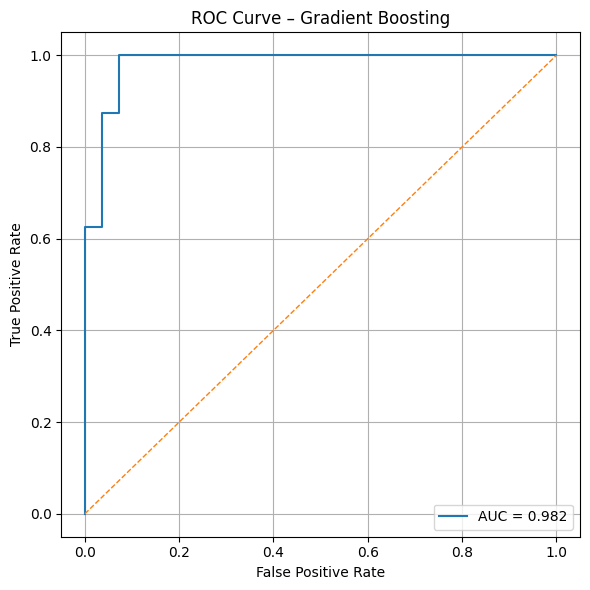

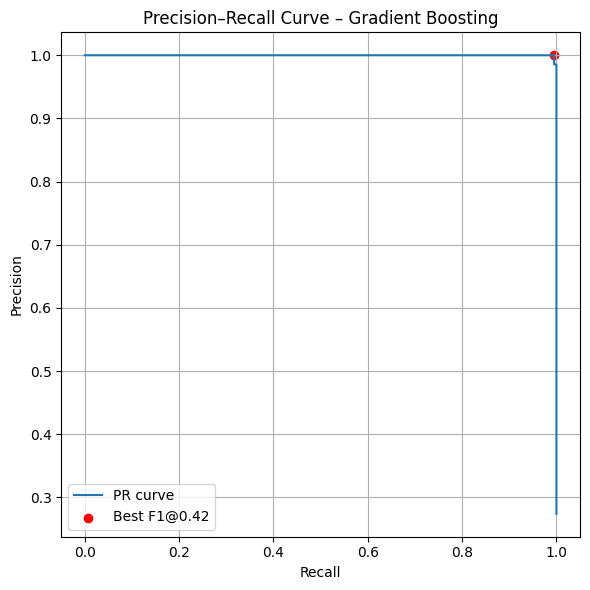

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# ─────────────────────────────────────────────────────
# 1. Load the full dataset
# ─────────────────────────────────────────────────────
df = pd.read_csv(
    r'C:\Users\ghkjs\GitHub\regime-shift-classification\data\processed\inflation_regime_dataset.csv',
    index_col=0,
    parse_dates=True
)

# ─────────────────────────────────────────────────────
# 2. Define a 36-month hold-out for final evaluation
# ─────────────────────────────────────────────────────
cutoff_date = df.index.max() - pd.DateOffset(months=36)

# ─────────────────────────────────────────────────────
# 3. Feature Engineering: drop Zscore, add lags & deltas
# ─────────────────────────────────────────────────────
df_feat = df.drop(columns=['Zscore'])

for col in ['CPI_YoY', 'Unemployment', 'M2_YoY', 'FedFunds']:
    df_feat[f'{col}_lag1']   = df_feat[col].shift(1)
    df_feat[f'{col}_delta1'] = df_feat[col] - df_feat[col].shift(1)

# Drop any rows with NaNs created by lagging
df_feat = df_feat.dropna()

# ─────────────────────────────────────────────────────
# 4. Split into train / test based on cutoff_date
# ─────────────────────────────────────────────────────
train = df_feat.loc[:cutoff_date]
test  = df_feat.loc[cutoff_date + pd.DateOffset(months=1):]

X_train = train.drop(columns=['Inflation_Regime'])
y_train = train['Inflation_Regime']
X_test  = test.drop(columns=['Inflation_Regime'])
y_test  = test['Inflation_Regime']

# ─────────────────────────────────────────────────────
# 5. Build & fit Gradient Boosting pipeline
# ─────────────────────────────────────────────────────
gb_pipeline = Pipeline([
    ('clf', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)

# ─────────────────────────────────────────────────────
# 6. Get predicted probabilities
# ─────────────────────────────────────────────────────
y_prob_train = gb_pipeline.predict_proba(X_train)[:, 1]
y_prob_test  = gb_pipeline.predict_proba(X_test)[:, 1]

# ─────────────────────────────────────────────────────
# 7. Evaluate at default 0.5 threshold
# ─────────────────────────────────────────────────────
y_pred_def = (y_prob_test > 0.5).astype(int)
print("=== Default Threshold (0.5) Evaluation ===")
print(classification_report(y_test, y_pred_def))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_test):.3f}\n")

# ─────────────────────────────────────────────────────
# 8. Tune threshold on the training set for best F1
# ─────────────────────────────────────────────────────
prec, rec, thr = precision_recall_curve(y_train, y_prob_train)
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_idx   = np.argmax(f1_scores)
best_thresh = thr[best_idx]
print(f"Best training-set F1 = {f1_scores[best_idx]:.2f} at threshold = {best_thresh:.2f}\n")

# ─────────────────────────────────────────────────────
# 9. Evaluate at the optimized threshold
# ─────────────────────────────────────────────────────
y_pred_opt = (y_prob_test > best_thresh).astype(int)
print("=== Optimized Threshold Evaluation ===")
print(classification_report(y_test, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_test):.3f}\n")

# ─────────────────────────────────────────────────────
# 10. Plot ROC Curve
# ─────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob_test):.3f}')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosting")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────
# 11. Plot Precision–Recall Curve with chosen threshold
# ─────────────────────────────────────────────────────
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label="PR curve")
plt.scatter(rec[best_idx], prec[best_idx],
            color='red', label=f'Best F1@{best_thresh:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Gradient Boosting")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()
